Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

Preprocessing dataset

In [ ]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
                                                                                                      

In [ ]:
train_dataset = image_dataset_from_directory(train_dir, shuffle=True,  batch_size=32, image_size=(160,160))

validation_dataset = image_dataset_from_directory(validation_dir,  shuffle=True, batch_size=32,  image_size=(160,160))                                                                                                                                                  

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Model


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,  weights='imagenet')                                                                                             

In [ ]:
#feature extraction
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 1)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,  epochs= 10,  validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 65s 976ms/step - loss: 3.2954 - accuracy: 0.6370 - val_loss: 0.9991 - val_accuracy: 0.8824
Epoch 2/10
63/63 [==============================] - 60s 953ms/step - loss: 1.6587 - accuracy: 0.8434 - val_loss: 0.5145 - val_accuracy: 0.9381
Epoch 3/10
63/63 [==============================] - 60s 957ms/step - loss: 1.0436 - accuracy: 0.8771 - val_loss: 1.4824 - val_accuracy: 0.8552
Epoch 4/10
63/63 [==============================] - 62s 975ms/step - loss: 1.7426 - accuracy: 0.8534 - val_loss: 0.7312 - val_accuracy: 0.9295
Epoch 5/10
63/63 [==============================] - 62s 990ms/step - loss: 1.0195 - accuracy: 0.9083 - val_loss: 0.6472 - val_accuracy: 0.9344
Epoch 6/10
63/63 [==============================] - 62s 976ms/step - loss: 1.3497 - accuracy: 0.8885 - val_loss: 0.3228 - val_accuracy: 0.9653
Epoch 7/10
63/63 [==============================] - 61s 973ms/step - loss: 1.2056 - accuracy: 0.9013 - val_loss: 1.7985 - val_accuracy: 0.8490

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Predictions:
 [0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1]
Labels:
 [0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1]


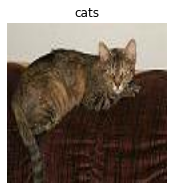

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)


plt.figure(figsize=(10, 10))
for i in range(1):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")